In [2]:
# reload magics
%load_ext autoreload
%autoreload 2

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datasets
from project_modules.io import load_dataset_to_df
from project_modules.classifcation import classify_MP,getXY, boruta_fs
from project_modules.utils import MPutils
from sklearn.ensemble import RandomForestClassifier
import multiprocessing
from sklearn.model_selection import cross_val_score
import cupy as cp
from datetime import datetime

from tqdm.notebook import tqdm
from copy import deepcopy

import umap
import matplotlib.colors as mc

import colorcet as cc
from sklearn.pipeline import Pipeline
# clustering
from sklearn.preprocessing import MinMaxScaler
from sklearn.manifold import TSNE
import json

import shap
# from project_modules.utils import get_logger
# logger = get_logger("log-data-combine-split.log")
# # read the parameter file

# from project_modules.utils import read_parameters
# parms = read_parameters("/Users/david/projects/lc-project-data/project.yaml")

pd.options.display.max_columns = None
pd.options.display.max_rows = 50

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [26]:
saveDir = MPutils.get_saving_dir('OUTPUT/MP/05-classifiers-plot/')

In [28]:
palette = cc.glasbey_hv

# create a palette dictionary that has the same keys as the original palette
palette_dict = {i: mc.to_hex(palette[i]) for i in range(len(palette))} # type: ignore

# add an entry for -1
palette_dict[-1] = '#ffffff'

# set default colour for seaborn heatmaps
sns.set_theme(style = "whitegrid", rc={'figure.figsize':(8,8)}, palette='viridis')

with open('JSON/selectFeaturePalette.json') as f: paletteSel = json.load(f)
with open('JSON/selectFeaturePalette_NiceFeat.json') as f: paletteSel_NF = json.load(f)
with open('JSON/selectFeaturePalette_NiceFeatFlipped.json') as f: paletteSel_NFF = json.load(f)


Import Data

In [38]:
# IMPORT DATA
import pickle
# Load data (deserialize)
with open('./OUTPUT/MP/GlobalHoldoutDataDict.pickle', 'rb') as handle:
    globalDict = pickle.load(handle)
    
globalDict.keys()

dict_keys(['featlist', 'site', 'data', 'savedir', 'featDir', 'selCols', 'x_h', 'y_h', 'x_Tr', 'y_Tr', 'x_h_scaled', 'umapRes', 'umap', 'holdoutDF'])

In [40]:
globalDict['holdoutDF'].LC_STATUS.value_counts()

LC_STATUS
0    661
1    437
Name: count, dtype: int64

## setup UMAP Figure

/home/mtrx/miniconda3/envs/clust/lib/python3.11/site-packages/umap/umap_.py:1393: RuntimeWarning: divide by zero encountered in power
  return 1.0 / (1.0 + a * x ** (2 * b))
/home/mtrx/miniconda3/envs/clust/lib/python3.11/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")
/tmp/ipykernel_7582/3498653423.py:26: UserWarning: The palette list has more values (256) than needed (2), which may not be intended.
  sns.scatterplot(data=dfumap, x=0, y=1, hue='LC',palette=cc.glasbey_hv, alpha=1, edgecolor='black', linewidth=0.5) #ax=ax[splot]


<Axes: xlabel='0', ylabel='1'>

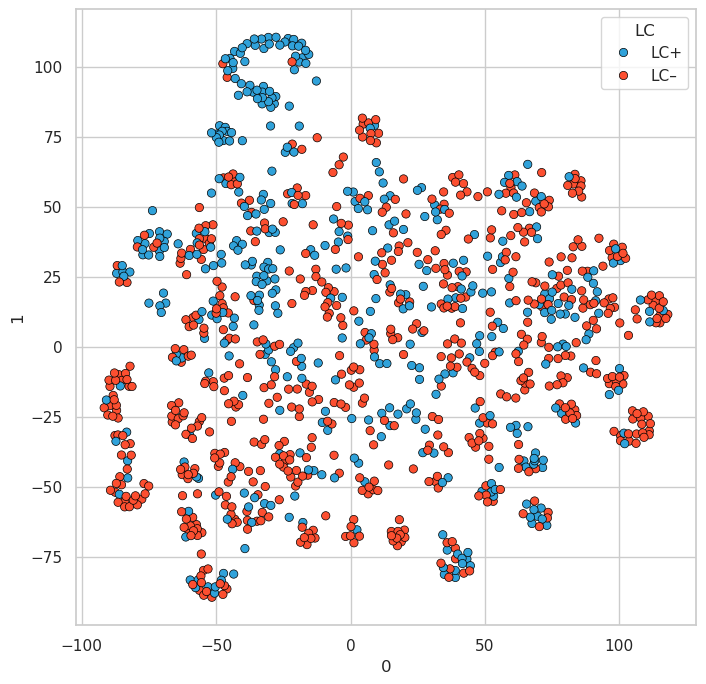

In [29]:
# UMAP
umap_parms = {
                'n_components': 2,
                'spread':       50.0,
                'random_state': 42,
                'n_neighbors': int(globalDict['x_h'].shape[0]*0.2),
                'min_dist': 0.1
            }

scaler = MinMaxScaler().set_output(transform = "pandas")
x_h_scaled = scaler.fit_transform(globalDict['x_h'])

globalDict['x_h_scaled'] = x_h_scaled

mapper = umap.UMAP(**umap_parms, verbose=False)
mapper.fit(x_h_scaled)


dfumap = pd.DataFrame(mapper.embedding_, index=x_h_scaled.index)
dfumap['LC'] = globalDict['data'].loc[x_h_scaled.index]['LC_STATUS'].map({0:'LC–',1:'LC+'})

globalDict['umapRes'] = mapper
globalDict['umap'] = dfumap

#plot umap
sns.scatterplot(data=dfumap, x=0, y=1, hue='LC',palette=cc.glasbey_hv, alpha=1, edgecolor='black', linewidth=0.5) #ax=ax[splot]

# setup SHAP

In [30]:
nicefeat = pd.read_csv('OUTPUT/MP/niceFeatures.csv')
nicefeat = nicefeat.set_index('feature')
nicefeatclean = nicefeat['clean'].to_dict()
nicefeatcleanflipped = nicefeat['clean_flip'].to_dict()

In [31]:
from project_modules.classifcation import _shap_analysis as davidShap

model = RandomForestClassifier(n_estimators=1000, max_depth=10,random_state=42)


x_Tr_global = deepcopy(globalDict['x_Tr']).rename(columns=nicefeatclean) #nicefeatcleanflipped
y_Tr_global = deepcopy(globalDict['y_Tr'])

x_h_global = deepcopy(globalDict['x_h']).rename(columns=nicefeatclean) #nicefeatcleanflipped


model.fit(x_Tr_global,y_Tr_global)

explainer = shap.TreeExplainer(model)

explanation = explainer(x_h_global)

In [33]:
dfShapFI = davidShap.shap_get_feature_importance(explainer,explanation,X=globalDict['x_h'],top_N=10)
dfShapFI['FeatureClean'] = dfShapFI.Feature.map(nicefeatclean)
dfShapFI['FeatureCleanFlipped'] = dfShapFI.Feature.map(nicefeatcleanflipped)
dfShapFI

>>> SHAP feature importance
--------------------------------------------------
>>> ... Top 10 features: ['VAX-vaccinated' 'age' 'SYMPT-dizziness___1' 'SYMPT-sore_throat___1'
 'SYMPT-runny_nose_rhinorrhea___1' 'SYMPT-shortness_of_breath_dyspne___1'
 'SYMPT-fatigue___1' 'SYMPT-cough___1' 'CD-medication_received___5'
 'SYMPT-chest_pain___1']


,Feature,Importance,FeatureClean,FeatureCleanFlipped
0,VAX-vaccinated,1.000000,Vaccinated,Vaccinated
1,age,0.956478,Age,Age
2,SYMPT-dizziness___1,0.881922,CoV Dizziness,Dizziness CoV
3,SYMPT-sore_throat___1,0.620386,CoV Sore Throat,Sore Throat CoV
4,SYMPT-runny_nose_rhinorrhea___1,0.574954,CoV Rhinorrhea,Rhinorrhea CoV
5,SYMPT-shortness_of_breath_dyspne___1,0.565062,CoV Dyspnea,Dyspnea CoV
6,SYMPT-fatigue___1,0.397254,CoV Fatigue,Fatigue CoV
7,SYMPT-cough___1,0.359044,CoV Cough,Cough CoV
8,CD-medication_received___5,0.330489,CoV Antibiotics,Antibiotics CoV
9,SYMPT-chest_pain___1,0.249684,CoV Chest Pain,Chest Pain CoV


# setup ROC

In [34]:
random_state = 42
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import RocCurveDisplay, auc

def plotROCCurve(ax,fontsize=10):
    n_splits = 5
    cv = StratifiedKFold(n_splits=n_splits)
    # classifier = svm.SVC(kernel="linear", probability=True, random_state=random_state)

    tprs = []
    aucs = []
    mean_fpr = np.linspace(0, 1, 100)

    classifier = RandomForestClassifier(n_estimators=1000,max_depth=10,random_state=42)

    X = deepcopy(tmpDict['x_h'])
    X.reset_index(drop=True,inplace=True)
    y = deepcopy(tmpDict['y_h'])
    y.reset_index(drop=True,inplace=True)

    for fold, (train, test) in enumerate(cv.split(X, y)):
        classifier.fit(X.iloc[train], y.iloc[train])
        viz = RocCurveDisplay.from_estimator(
            classifier,
            X.iloc[test],
            y.iloc[test],
            name=f"ROC fold {fold}",
            alpha=0.3,
            lw=1,
            ax=ax,
            plot_chance_level=(fold == n_splits - 1),
        )
        interp_tpr = np.interp(mean_fpr, viz.fpr, viz.tpr)
        interp_tpr[0] = 0.0
        tprs.append(interp_tpr)
        aucs.append(viz.roc_auc)

    mean_tpr = np.mean(tprs, axis=0)
    mean_tpr[-1] = 1.0
    mean_auc = auc(mean_fpr, mean_tpr)
    std_auc = np.std(aucs)
    ax.plot(
        mean_fpr,
        mean_tpr,
        color="b",
        label=r"Mean ROC (AUC = %0.2f $\pm$ %0.2f)" % (mean_auc, std_auc),
        lw=2,
        alpha=0.8,
    )

    std_tpr = np.std(tprs, axis=0)
    tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
    tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
    ax.fill_between(
        mean_fpr,
        tprs_lower,
        tprs_upper,
        color="grey",
        alpha=0.2,
        label=r"$\pm$ 1 std. dev.",
    )

    ax.set(
        xlabel="False Positive Rate",
        ylabel="True Positive Rate",
        # title=f"Mean ROC curve with variability",
        title='ROC Curve',
    )
    ax.legend(loc="lower right",fontsize=8)

# Plot Fig 1

/tmp/ipykernel_7582/1769685994.py:10: UserWarning: The palette list has more values (256) than needed (2), which may not be intended.
  sns.scatterplot(data=globalDict['umap'], x=0, y=1, hue='LC',palette=cc.glasbey_hv, alpha=0.5, ax=ax['B'], edgecolor='black', linewidth=0.5, s=25)


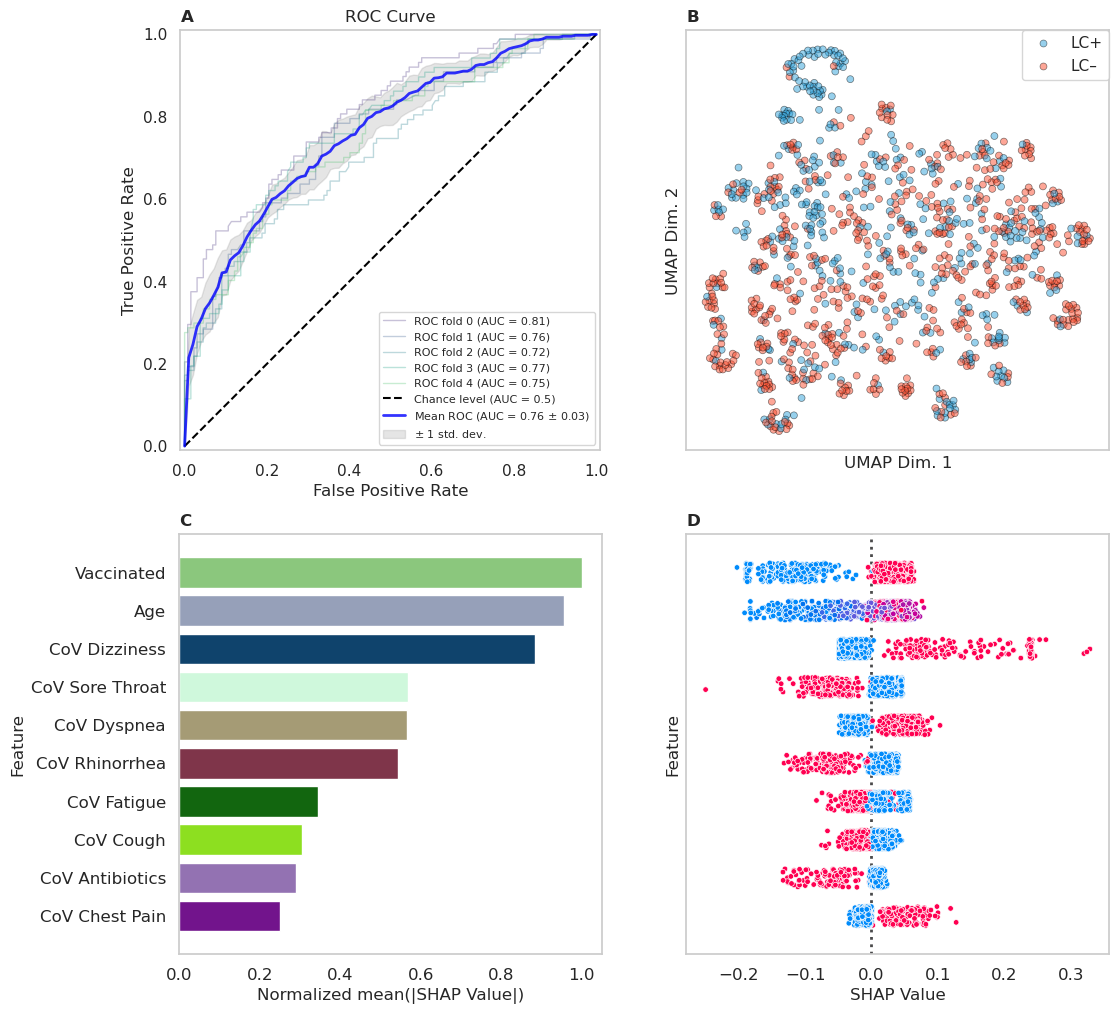

In [36]:
fontsize='medium'
sString = 'AB;CD'
fig, ax = plt.subplot_mosaic(sString,figsize=(12,12))

# PLOT ROC CURVE
plotROCCurve(ax['A'],fontsize)

# PLOT UMAP/SCATTER
sns.scatterplot(data=globalDict['umap'], x=0, y=1, hue='LC',palette=cc.glasbey_hv, alpha=0.5, ax=ax['B'], edgecolor='black', linewidth=0.5, s=25)

#setup plot
ax['B'].legend(bbox_to_anchor=(1, 1), loc=1, borderaxespad=0.)
ax['B'].set_xticks([]); ax['B'].set_yticks([])
ax['B'].set_xlabel("UMAP Dim. 1"); ax['B'].set_ylabel("UMAP Dim. 2")


# SHAP BAR
davidShap.shap_plot_bar(ax=ax['C'], explanation=explanation, X= x_h_global,target_class=1,plot_n_features=10,feature_palette=paletteSel_NF,fontsize=fontsize)


#SHAP Points
davidShap.shap_plot_points(ax=ax['D'], explanation=explanation, X= x_h_global,target_class=1,plot_n_features=10,fontsize=fontsize,normalize_values=False, suppress_yticks=True)

# GRID OFF
ax['A'].grid(False)
ax['B'].grid(False)
ax['C'].grid(False)
ax['D'].grid(False)

#set AB subplot identifier letters
ax['A'].set_title('A',  loc='left', fontsize='medium', fontweight='bold')
ax['B'].set_title('B', loc='left', fontsize='medium', fontweight='bold')
ax['C'].set_title('C', loc='left', fontsize='medium', fontweight='bold')
ax['D'].set_title('D', loc='left', fontsize='medium', fontweight='bold')

# SAVE
# plt.savefig(f'{saveDir}/Fig1-Global/Fig1-Global-ROC-UMAP-SHAPFR-SHAPVal.jpg', dpi=800, bbox_inches='tight', facecolor='white')